# Import necessery libraries

In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import numpy as np
import pandas as pd
from glob import glob

# Load filepath and set constant image size

In [3]:
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/My Drive/datasets/Plants/Pepper/train'
validation_path = '/content/drive/My Drive/datasets/Plants/Pepper/valid'

# Check data path to know how many categories impoved

In [4]:
from glob import glob
folders = glob('/content/drive/My Drive/datasets/Plants/Pepper/train/*')
folders

['/content/drive/My Drive/datasets/Plants/Pepper/train/Pepper,_bell___Bacterial_spot',
 '/content/drive/My Drive/datasets/Plants/Pepper/train/Pepper,_bell___healthy']

# Observe the data in the dataset
It is important to observe how th data is distributed across all categories. This is to know if you are working with balanced or imbalanced dataset

In [5]:
def observe_data(fpath):
  import os
  import pandas as pd
  import matplotlib.pyplot as plt

  data = {}

  plant_classes = [x[0] for x in os.walk(fpath) ]
  for fpath in plant_classes[1:]:
    items = os.listdir(fpath)
    data[fpath.split('___')[-1]] = len(items)
    
  df = pd.DataFrame(list(data.items() ), columns=['class', 'number of images'])

  plt.bar(df['class'], df['number of images'], color='rgbkymc')
  for index, value in enumerate(df['number of images']):
      s = '{}'.format(value)
      plt.text(index,value , str(s), fontsize=8)
  plt.xticks(rotation=90)
  plt.show()
  return df


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  from ipykernel import kernelapp as app


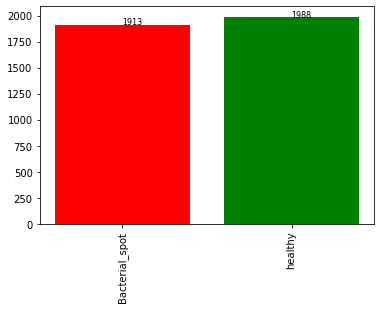

In [6]:
df = observe_data(train_path)

# Using a pretrained network to build the model
## Instantiating the inception V3 convolutional base

In [7]:
inception_conv_base = InceptionV3(input_shape= IMAGE_SIZE + [3],
                        weights='imagenet',
                        include_top=False)

## Freezing the Layers
This is to prevent the weight of the layers from updating during training. If this is not done, the representations that were previously learned by the convolutional base will be modified during training

In [8]:
for layer in inception_conv_base.layers:
  layer.trainable=False

## Flatten the model and create the ouput layer

In [9]:
model = Sequential()
model.add( inception_conv_base )
model.add( Flatten() )
model.add( Dense(len(folders), activation='softmax') )

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 102402    
Total params: 21,905,186
Trainable params: 102,402
Non-trainable params: 21,802,784
_________________________________________________________________


## Set the model optimizer

In [11]:
model.compile( loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## input processing and image argumentation 


In [12]:
train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=40,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True)

# Validation set should not be argumented
test_datagen = ImageDataGenerator(rescale=1./255)

## Callbacks

In [13]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

base_dir = '/content/drive/My Drive/datasets/Plants/Pepper'


earlystopping = EarlyStopping(              # interrupts training when improvement stops
                  monitor='val_accuracy',   # Monitors the model’s validation accuracy
                  patience=4 )              # Interrupt when model doesn't increase after 4 steps


learning_rate_reduction = ReduceLROnPlateau(
                  monitor='val_accuracy',   # Monitors the model’s validation accuracy
                  patience=2,               # change the learning rate after 2 steps
                  verbose=1, 
                  factor=0.5, 
                  min_lr=0.00001)


checkpoint =  ModelCheckpoint(                           # Saves the current weights after every epoch
                  filepath=base_dir + '/my_model_checkpoint.h5',     # Path to the destination model file

                  # These two arguments mean you won’t overwrite the
                  # model file unless val_loss has improved, which allows
                  # you to keep the best model seen during training.
                  monitor='val_loss',
                  save_best_only=True
                )


# Train generator

In [14]:
train_generator = train_datagen.flow_from_directory(
                train_path,                  # target directory
                target_size=IMAGE_SIZE,      # resize image to 224 x 224
                batch_size=20,
                class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
                validation_path,
                target_size=IMAGE_SIZE,
                batch_size=20,
                class_mode='categorical')

Found 3901 images belonging to 2 classes.
Found 975 images belonging to 2 classes.


# Train the model

In [15]:
%time
from time import time

start = time()

history = model.fit_generator(
            train_generator,
            validation_data=validation_generator,
            epochs=20,
            steps_per_epoch=len(train_generator),
            validation_steps=len(validation_generator),
            callbacks=[earlystopping, checkpoint])

# save model
model.save(base_dir + '/pepper_inception_v3_2.h5')
print('\n\nDuration: {} seconds'.format(time() - start))

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.11 µs
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
196/196 [==============================] - 1945s 10s/step - loss: 1.2538 - accuracy: 0.8598 - val_loss: 0.3466 - val_accuracy: 0.9436
Epoch 2/20
196/196 [==============================] - 56s 284ms/step - loss: 0.6799 - accuracy: 0.9113 - val_loss: 0.7031 - val_accuracy: 0.9067
Epoch 3/20
196/196 [==============================] - 57s 293ms/step - loss: 0.6572 - accuracy: 0.9231 - val_loss: 0.2769 - val_accuracy: 0.9651
Epoch 4/20
196/196 [==============================] - 54s 277ms/step - loss: 1.1688 - accuracy: 0.9093 - val_loss: 0.3292 - val_accuracy: 0.9641
Epoch 5/20
196/196 [==============================] - 53s 271ms/step - loss: 0.7548 - accuracy: 0.9390 - val_loss: 1.2139 - val_accuracy: 0.9118
Epoch 6/20
196/196 [==============================] - 53s 273ms/step - loss: 0.8348 - accuracy: 0.9321 - val_loss: 0.6855 - val_acc

In [16]:
test_loss, test_acc = model.evaluate_generator(validation_generator, steps=50)
print('test acc:', test_acc)
print('test loss:', test_loss)

Instructions for updating:
Please use Model.evaluate, which supports generators.
test acc: 0.9015384912490845
test loss: 1.1218950748443604


# Check the model evaluation save by callbacks checkpoint
Check the model saved to see the one that perform the most

In [19]:
from tensorflow.keras.models import Sequential, save_model, load_model
import numpy as np

IMAGE_SIZE = [224, 224]
filepath = '/content/drive/My Drive/datasets/Plants/Pepper/my_model_checkpoint.h5'

model_2 = load_model(
    filepath,
    custom_objects=None,
    compile=True)

test_loss, test_acc = model_2.evaluate_generator(validation_generator, steps=50)
print('test acc:', test_acc)


test acc: 0.9651281833648682


## Plot

In [ ]:
def plot_history(history):
    import pandas as pd
    import matplotlib.pyplot as plt
    history_dict = history.history
    df = pd.DataFrame(history_dict)

    plt.rcParams['figure.figsize'] = [10, 3.5]
    fig, axs = plt.subplots(1, 2)
    plt.subplots_adjust(hspace=0.5, wspace=0.2)
    p1, p2 = axs[0], axs[1]

    epochs = range(1, len(df.index) + 1)
    p1.plot(epochs, df[df.columns[0]], 'ro', label='Training loss')
    p1.plot(epochs, df[df.columns[2]], 'r', label='Validation loss')
    p1.set_title('Training and validation loss')
    p1.set_xlabel('Epochs')
    p1.set_ylabel('Loss')
    p1.legend()

    p2.plot(epochs, df[df.columns[1]], 'bo', label='Training acc')
    p2.plot(epochs, df[df.columns[3]], 'b', label='Validation acc')
    p2.set_title('Training and validation accuracy')
    p2.set_xlabel('Epochs')
    p2.set_ylabel('Accuracy')
    p2.legend()

    plt.show()

plot_history(history)

# Load Model

In [ ]:
%time
from tensorflow.keras.models import Sequential, save_model, load_model
import numpy as np

IMAGE_SIZE = [224, 224]
filepath = '/content/drive/My Drive/datasets/Plants/Pepper/Pepper_inception_v3.h5'

model = load_model(
    filepath,
    custom_objects=None,
    compile=True)

In [ ]:
from glob import glob
folders = glob('/content/drive/My Drive/datasets/Plants/Potato/train/*')
labels = [ x.split('___')[-1] for x in folders]
labels

# Testing the what thw model accuracy looks like

In [ ]:
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = [224, 224]
batch_size = 15
test_path = '/content/drive/My Drive/datasets/Plants/Pepper/valid/Pepper,_bell___Bacterial_spot'

test_filenames = os.listdir(test_path)
test_df = pd.DataFrame({'filename': test_filenames})

nb_samples = test_df.shape[0]

test_gen = ImageDataGenerator(rescale=1./255)

test_set = test_gen.flow_from_dataframe(
    test_df, 
    test_path, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False)

# Predict

In [ ]:
predict = model.predict_generator(test_set, steps=np.ceil(nb_samples/batch_size))

In [ ]:
test_df['raw_category'] = 0
test_df['category'] = np.argmax(predict, axis=-1)

for i in range(len(test_df)):
  x = test_df['category'].iloc[i]
  test_df['raw_category'].iloc[i] = predict[i][x]
# test_df['raw_category'] = test_df['category'].apply(lambda x: predict[x])
test_df.head()

In [ ]:
test_df.category.value_counts()

In [ ]:
test_df.raw_category.min()

In [ ]:
fil = test_df['category'] != 0
test_df[ fil ].head(20)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing.image import load_img

def show_img(test_df, fil):
  """
  """

  sample_test = test_df[fil].head(18)
  sample_test.head()
  plt.figure(figsize=(12, 24))

  i = 0
  for index, row in sample_test.iterrows():
      i += 1

      filename = row['filename']
      category = row['raw_category']
      c = row['category']

      if category >= 0.5:
          animal = 'Dog'
      else:
          animal = 'Cat'

      # print(index)
      img = load_img(test_path + '/' + filename, target_size=IMAGE_SIZE)
      plt.subplot(6, 3, i)
      plt.imshow(img)
      plt.xlabel(f'{filename.split(" ")[-1]} \n{labels[c]}' + '- (' + "{:.2f}".format(category) + ')' )
  plt.tight_layout()
  plt.show()

In [ ]:
# fil = (test_df['raw_category'] > 0.5) & (test_df['raw_category'] < 0.9)
fil = test_df['category'] != 0

plot(test_df, fil)

# Training model with callbacks

In [ ]:
from time import time

start = time()

history = model.fit_generator(
            train_generator,
            validation_data=validation_generator,
            epochs=20,
            steps_per_epoch=len(train_generator),
            validation_steps=len(validation_generator),
            callbacks=[earlystopping, checkpoint])

print('\n\nDuration: {} seconds'.format(time() - start))


In [ ]:
plot_history(history)

In [ ]:
test_loss, test_acc = model.evaluate_generator(validation_generator, steps=50)
print('test acc:', test_acc)
print('test loss:', test_loss)

In [ ]:
test_loss, test_acc = model_1.evaluate_generator(validation_generator, steps=50)
print('test acc:', test_acc)
print('test loss:', test_loss)

In [ ]:
%time
from tensorflow.keras.models import Sequential, save_model, load_model
import numpy as np

IMAGE_SIZE = [224, 224]
filepath = '/content/drive/My Drive/datasets/Plants/Potato/my_model_checkpoint.h5'

model_2 = load_model(
    filepath,
    custom_objects=None,
    compile=True)

test_loss, test_acc = model_2.evaluate_generator(validation_generator, steps=50)
print('test acc:', test_acc)
print('test loss:', test_loss)